In [8]:
!pip install datasets --upgrade

In [11]:
!pip install datasets transformers --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 51.9 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.52.2
    Uninstalling transformers-4.52.2:
      Successfully uninstalled transformers-4.52.2


In [2]:
from huggingface_hub import login

login()

In [3]:
from datasets import load_dataset
from transformers import AutoTokenizer


dataset = load_dataset("brighter-dataset/BRIGHTER-emotion-categories", "eng")
label_names = ['joy', 'sadness', 'anger', 'fear', 'surprise']

# Use a pretrained Hugging Face model
model_name = "meta-llama/Llama-3.2-1B"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

def preprocess(example):
    # Tokenize text
    tokenized = tokenizer(example["text"], truncation=True, padding="max_length", max_length=128)
    # Get labels
    tokenized["labels"] = [float(example[label]) for label in label_names]
    return tokenized

encoded_dataset = dataset.map(preprocess, batched=False)




Map:   0%|          | 0/232 [00:00<?, ? examples/s]

In [5]:

from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch
import numpy as np
from sklearn.metrics import f1_score, accuracy_score


# Load model
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=5,
    problem_type="multi_label_classification",
    pad_token_id=tokenizer.eos_token_id
)



for param in model.base_model.parameters():
    param.requires_grad = False

# freeze the entire base model
for param in model.base_model.parameters():
    param.requires_grad = False

# Collect unfrozen transformer layer parameters
unfrozen_params = []
for name, param in model.named_parameters():
    if "model.layers" in name and any(layer_id in name for layer_id in ["14", "15"]):
        param.requires_grad = True
        unfrozen_params.append(param)


head_params = []
for name, param in model.named_parameters():
    if param.requires_grad and all(x not in name for x in ["model.layers"]):
        head_params.append(param)


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-3.2-1B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
from torch.optim import AdamW
from transformers import EarlyStoppingCallback

optimizer_grouped_parameters = [
    {"params": head_params, "lr": 1e-5},        # Classifier head
    {"params": unfrozen_params, "lr": 1e-6},    # Unfrozen transformer layers
]

def custom_optimizer(model):
    return AdamW(optimizer_grouped_parameters, weight_decay=0.01)


# Custom metrics
def compute_metrics(eval_pred):
    from sklearn.metrics import f1_score
    logits, labels = eval_pred
    probs = torch.sigmoid(torch.tensor(logits)).numpy()
    predictions = (probs > 0.5).astype(int)
    return {
        "f1_micro": f1_score(labels, predictions, average="micro"),
        "f1_macro": f1_score(labels, predictions, average="macro"),
    }

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    report_to="none",
    eval_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=6,
    per_device_eval_batch_size=6,
    num_train_epochs=8,
    weight_decay=0.01,
    logging_dir="./logs",
    metric_for_best_model="f1_macro",
    load_best_model_at_end=True,
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    #callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
    optimizers=(custom_optimizer(model), None)

)


<ipython-input-6-17fef9c2f7ad>:42: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [7]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1 Micro,F1 Macro
1,0.515500,0.438644,0.645416,0.533700
2,0.392300,0.387591,0.687112,0.614359
3,0.351600,0.383284,0.693667,0.622960
4,0.325300,0.367238,0.717650,0.666845
5,0.306800,0.367951,0.723945,0.666649
6,0.292000,0.363423,0.723925,0.675331
7,0.280800,0.362367,0.722499,0.680652
8,0.274300,0.361575,0.725449,0.682087


TrainOutput(global_step=3696, training_loss=0.34233327551837606, metrics={'train_runtime': 7302.6258, 'train_samples_per_second': 3.032, 'train_steps_per_second': 0.506, 'total_flos': 1.6550073030672384e+16, 'train_loss': 0.34233327551837606, 'epoch': 8.0})

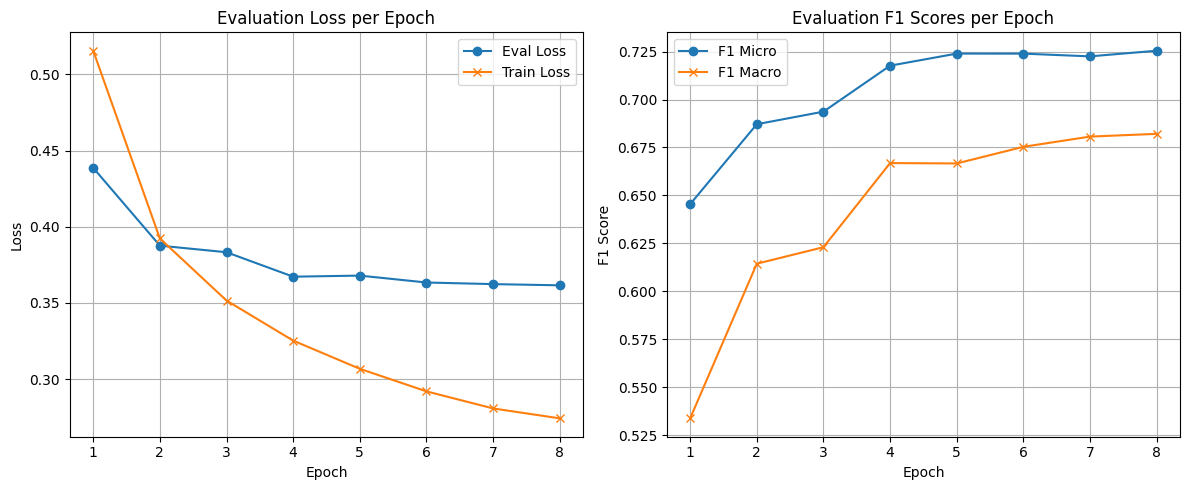

In [8]:
import matplotlib.pyplot as plt

# Extract log history (includes training and eval logs)
log_history = trainer.state.log_history

# Separate values
train_epochs = []
train_loss = []
eval_epochs = []
eval_loss = []
eval_f1_micro = []
eval_f1_macro = []

for log in log_history:
    if "loss" in log and "epoch" in log and "eval_loss" not in log:
        train_epochs.append(log["epoch"])
        train_loss.append(log["loss"])
    if "eval_loss" in log:
        eval_epochs.append(log["epoch"])
        eval_loss.append(log["eval_loss"])
        eval_f1_micro.append(log["eval_f1_micro"])
        eval_f1_macro.append(log["eval_f1_macro"])

# Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(eval_epochs, eval_loss, marker='o', label="Eval Loss")
plt.plot(train_epochs, train_loss, marker='x', label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Evaluation Loss per Epoch")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(eval_epochs, eval_f1_micro, marker='o', label="F1 Micro")
plt.plot(eval_epochs, eval_f1_macro, marker='x', label="F1 Macro")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("Evaluation F1 Scores per Epoch")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()